In [1]:
from QwenMCQA_M3 import *
import random
import numpy as np
from functools import partial

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
def legacy_prompt(example, cot_prob = None):
	topic = "knowledge and skills in advanced master-level STEM courses"
	lines = [
		f"The following are multiple choice questions (with answers) about {topic}.",
		"",
		example["question"],
	]
	for label, option in zip(["A","B","C","D","E"], example["options"]):
		lines.append(f"{label}. {option}")
	lines.append("Answer:")
	prompt = "\n".join(lines)
	return prompt, example['label']


def cot_prompt(example, cot_prob = 0.5):
	subjects = {'aqua_rat' : 'math',
				'medmcqa' : 'medicine',
				'mmlu_aux' : 'STEM',
				'openbookqa' : 'STEM',
				'sciq' : 'STEM',
				'race' : 'STEM'}
	
	topic = f"knowledge and skills in advanced master-level {subjects[example['dataset']]} courses"
	setup = f'The following are multiple choice questions (with answers) about {topic}.\n'

	cot = ''
	doing_cot = random.random() < cot_prob
	if example['rationale'] != "" and doing_cot:
		cot = f'Think step by step (before answering).\n<think>\n{example["rationale"]}\n</think>'

	golden_idx = example["label_idx"]
	labels = ['A', 'B', 'C', 'D', 'E']
	golden_answer = labels[golden_idx]

	options = [f"{label}. {option}".strip() for label, option in zip(labels, example["options"])]

	cot_and_answer = [cot, 'Answer:'] if doing_cot else ['Answer:']
	lines = [setup, example["question"]] + options + cot_and_answer

	return '\n'.join(lines), golden_answer

def preprocess(example,
			   tokenizer,
			   max_length,
			   tokenized_marker,
               prompt_function,
			   cot_prob):

	def find_last_subseq(seq, pat):
		for i in range(len(seq) - len(pat), -1, -1):
			if seq[i : i+len(pat)] == pat:
				return i + len(pat) - 1
		raise ValueError("Could not find marker")

	prompt, golden_answer = prompt_function(example, cot_prob)

	choice_ids = tokenizer.encode(f" {golden_answer}", add_special_tokens=False)
	n_answer = len(choice_ids)

	tok = tokenizer(
		prompt,
		max_length=max_length - n_answer,
		truncation=True,
		padding=False,
	)

	pad_len = max_length - len(tok["input_ids"])
	tok["input_ids"]      += [tokenizer.pad_token_id] * pad_len
	tok["attention_mask"] += [0] * pad_len

	labels = [-100] * max_length
	ans_pos = find_last_subseq(tok["input_ids"], tokenized_marker)
	if ans_pos + 1 + n_answer > max_length:
		raise ValueError("Not enough room for answer tokens")
	for i, tid in enumerate(choice_ids):
		labels[ans_pos + 1 + i] = tid

	return {
		"input_ids":      tok["input_ids"],
		"attention_mask": tok["attention_mask"],
		"labels":         labels,
	}

In [3]:
p = 1
#prompt_function = legacy_prompt
prompt_function = cot_prompt
preprocess_f = partial(preprocess, 
                       prompt_function = prompt_function, 
                       cot_prob=p)

qwenMCQA = QwenMCQA(
            preprocess_f,
            #my_model_name = "MNLP_M3_mcqa_model"   #<----- CHANGE THIS
            my_model_suffix = "cot00_b32",   #<----- CHANGE THIS
            num_epochs = 3,
            #learning_rate = 1e-4,
            batch_size = 32,
            gradient_accumulation_steps = 1,
            #hf_token: str = "your_hf_token",  #<----- CHANGE THIS
            #hf_username: str = "your_hf_username",  #<----- CHANGE THIS
            )

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB MIG 3g.20gb. Num GPUs = 1. Max memory: 19.625 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


/home/my_venvs/mnlp_m2c/lib/python3.12/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


Unsloth: Making `model.base_model.model.model` require gradients


/home/my_venvs/mnlp_m2c/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/home/my_venvs/mnlp_m2c/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 250,000 | Num Epochs = 3 | Total steps = 23,439
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 66,060,288/6,000,000,000 (1.10% trained)


Starting training with LoRA adapters...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.607000
20,2.377800
30,2.484000
40,2.297900
50,2.253000
60,1.989600
70,1.772800
80,1.516200
90,1.482400
100,1.431600


Unsloth: Will smartly offload gradients to save VRAM!


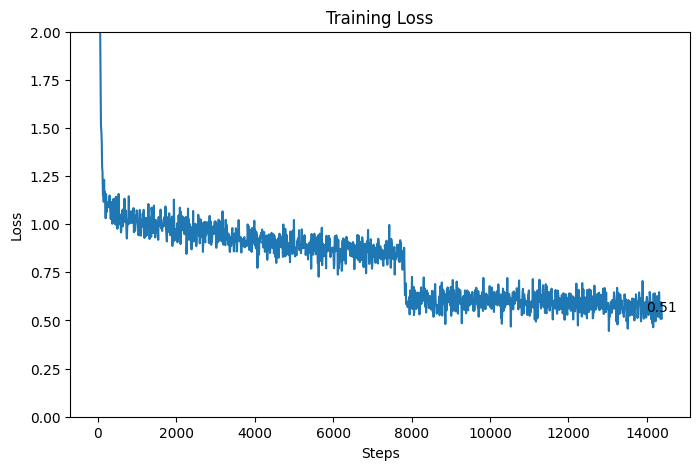

In [ ]:
qwenMCQA.train()
qwenMCQA.merge()